
<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">EM Connectomics</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Monday, August 29, 2022</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>In this session, we introduce how to query the anotation database and give a flavor of how to use the results to do some simple analysis. By the end, you should be able to query for neurons, query for synapses between those neurons, and visualize the neurons and synapes.

</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Background</h2>

<p>
This dataset is part of a collaboration between the Tolias lab at Baylor,
the Allen Institute, and Sebastian Seung's lab at Princeton University,
as part of the IARPA Microns project.  
</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Local setup instructions</h2>

<p>
Because this dataset is part of a collaboration, it has not been packaged 
through the usual AllenSDK mechanism.  Working with Princeton we have developed  packages for querying and visualizing the data. They should be installed by creating a new anaconda environment using the environment.yml file found in this repo. 
</p>





<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Drive Path</h2>
First we need to know where the data is on your system.  If you are running on Linux or Windows, edit this cell to reflect where the data is.  If on AWS or mac the location here is likely correct.

</div>


In [1]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2022/em-connectomics-data"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/em-connectomics-data"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/em-connectomics-data/"
    
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2021/em-connectomics-data"
    
# OR if you'd like to override the auto options
# data_root = "."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Import the key modules</h2>
Our analysis workflows use a couple of special purpose packages we have developed. Here, we are going to look at the CAVEclient (Connectome Annotation Versioning Engine), our package that quickly performs simple analysis queries and produces tidy Pandas dataframes.
</div>

In [2]:
# this is the EM specific package for querying the EM data
from caveclient import CAVEclient


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Import some of our favorite modules</h2>
Our analysis workflows uses many of the common scientific computing packages like Numpy and Pandas.
</div>

In [3]:
# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Setting up a CAVE account </h2>

CAVE is the Connectome Annotation Versioning Engine.
It is a collection of services which manage proofreading and data annotation for large scale connectomics dataset.
These services were developed during the IARPA MICrONS program, but now support data from several projects including FlyWire.  You need to have an account on CAVE to use its services.

To get an account please first go to this [website](https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public_v117)

You should be prompted to login with a google account and then you must seperately accept the terms and conditions.

Once you have registered, you can then follow along this notebook.
This notebook will show you how to get a programatic token that you can use to authenticate to the services in order to make queries. The token can then be used on different computers.

<h2>Setting key parameters </h2>
A 'datastack' is a combination of image and segmentation data.  The cortical mm^3 datastack that we are going to use is called `minnie65_public_v343` named because it is approximately 65% of the whole volume, and its the public releasse that corresponds to the 343th iteration of proofreading results we aggregated. (one of two we made public v117 being the other)
</div>


In [4]:
client = CAVEclient()

# WARNING if you have a CAVE account and haven't setup this computer
# DO NOT JUST RUN THIS CELL WITHOUT READING

# this will detect if this computer has saved a token already
# and skip the setup if it has. If its not working because
# for example, you accidently invalidated your token
# you will need to bypass this if
if not os.path.isfile(client.auth._token_file):
    # this assumes that you need to setup a token
    # it will invalidate any tokens you already setup
    client.auth.setup_token(make_new=True)

    # if you have already used MICRONS or FlyWire,
    # and setup a different computer you might 
    # want to use this instead to not invalidate your old tokens
    # client.auth.setup_token(make_new=False)

In [5]:
# if you have not yet setup this computer, uncomment this below line
# paste the token from the website in, and run the line

# client.auth.save_token(token="paste_token_here", overwrite=True)

# then comment or delete the line as you don't need to run it on this computer  again

In [6]:
datastack_name = 'minnie65_public_v343'

client = CAVEclient(datastack_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Terms of Service Error</h2>
If for some reason you are getting an error that says you haven't signed the terms of service, visit this link.

<a href="https://global.daf-apis.com/sticky_auth/api/v1/tos/2/accept"> Microns Public TOS </a>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Client Basics</h2>
The client lets you connect to a number of different services via service specific clients, and you can read about all of them in  <a href="https://caveclient.readthedocs.io/">the CAVEclient documentation</a>.

The base client class has properties that let you access the sub-clients for each service. 

For this notebook however we will focus on the 'materialize' sub-client which lets you interact with the 'materialization' service to access tables of annotations on the data, including cells, nuclei, cell types and synapses. 

To see what tables are available, use the 'get_tables' method on the materialize sub-client.
</div>

In [7]:
client.materialize.get_tables()

['synapses_pni_2',
 'nucleus_neuron_svm',
 'nucleus_detection_v0',
 'functional_coreg',
 'allen_v1_column_types_slanted',
 'aibs_column_nonneuronal',
 'func_unit_em_match_release',
 'proofreading_status_public_release',
 'aibs_soma_nuc_metamodel_preds_v117']

In [8]:
# For each table you can get metadata about that table
client.materialize.get_table_metadata('nucleus_detection_v0')
# in this case you can see that it's a table that contains a list of all the automated
# nucleus detections in the dataset, useful for finding cells with cell bodies.

{'valid': True,
 'table_name': 'nucleus_detection_v0',
 'aligned_volume': 'minnie65_phase3',
 'created': '2020-09-28T22:39:06.523707',
 'schema': 'nucleus_detection',
 'id': 8214,
 'schema_type': 'nucleus_detection',
 'user_id': '121',
 'reference_table': None,
 'description': 'A table of nuclei detections from a nucleus detection model developed by Shang Mu, Leila Elabbady, Gayathri Mahalingam and Forrest Collman. Pt is the centroid of the nucleus detection. id corresponds to the flat_segmentation_source segmentID. Only included nucleus detections of volume>25 um^3, below which detections are false positives, though some false positives above that threshold remain. ',
 'flat_segmentation_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/nuclei',
 'voxel_resolution': [4.0, 4.0, 40.0]}

In [9]:
# and how many annotations are in it
# the maybe most important table is the synapse table (synapses_pni_2)
# which has >330 million synapses, so querying its length takes a long time
client.materialize.get_annotation_count('nucleus_detection_v0')


144120

In [10]:
# lets look at the proofreading status table
# if you ask for the whole thing, the client will give you the first 200K rows
# which is good enough to cover everything other than synapses
prf_df= client.materialize.query_table('proofreading_status_public_release')
prf_df.head()

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,4,t,91077153340676495,864691135355207375,864691135355207375,extended,non,"[191424, 209888, 22845]"
1,7,t,91570559116360958,864691136602027473,864691136602027473,extended,non,"[194864, 216128, 22205]"
2,8,t,90444453118345856,864691135866846742,864691135866846742,extended,non,"[186768, 214288, 22811]"
3,9,t,89741246779911895,864691135445832338,864691135445832338,extended,non,"[181312, 217904, 23251]"
4,13,t,91499640750531825,864691135569255558,864691135569255558,extended,non,"[194112, 212064, 23175]"


In [11]:
# so what do those columns mean?
# you can check the metadata!
prf_metadata=client.materialize.get_table_metadata('proofreading_status_public_release')
# you could print it out like this, but we've added it to the markdown below
# with the column descriptions
#prf_metadata['description']

<h3> Proofreading Status Descriptions</h3>
prf_metadata['description']="The proofreading status of neurons that have been comprehensively proofread within this version. Axon and dendrite compartment status are marked separately under 'axon_status' and 'dendrite_status', as proofreading effort was applied differently to the different compartments in some cells. There are three possible status values for each compartment: 'non' indicates no comprehensive proofreading. 'clean' indicates that all false merges have been removed, but all tips have not necessarily been followed. 'extended' indicates that the cell is both clean and all tips have been followed as far as a proofreader was able to. The 'pt_position' is at a cell body or similar core position for the cell. The column 'valid_id' provides the root id when the proofreading was last checked. If the current root id in 'pt_root_id' is not the same as 'valid_id', there is no guarantee that the proofreading status is correct. Very small false axon merges (axon fragments approximately 5 microns or less in length) were considered acceptable for clean neurites. Note that this table does not list all edited cells, but only those with comprehensive effort toward the status mentioned here. Table compiled by Sven Dorkenwald and Casey Schneider-Mizell, including work by many proofreaders and data maintained by Stelios Papadopoulos."
<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>valid</td>
        <td>A bookkeeping column, should always be 't'</td>
    </tr>
    <tr>
        <td>pt_position</td>
        <td>This is the x,y,z location in voxels of the point that was annotated here as being at this cells soma location. Note, this table has a voxel resolution of 4,4,40 nm, and so you might want to convert this column to a nm position, using thew.  </td>
    </tr>
    <tr>
        <td>pt_supervoxel_id</td>
        <td>You can generally ignore this column, we keep it for bookkeeping in order to make it easier to update this annotation when the segmentation changes.  </td>
    </tr>
    <tr>
        <td>pt_root_id</td>
        <td>This is the unique ID of the 'root' object in the segmentation, sometimes we refer to this as a segmentation id or a cell id.</td>
    </tr>
    <tr>
        <td>valid_id</td>
        <td>This is the ID of the object when this proofreading status was applied, for this release, this column matches the pt_root_id and so can be ignored.  Its here to help alert us if the object changed since the human who judged this neuron to be 'clean' for example.  In such case its possible theoretically that the cell is no longer 'clean'.</td>
    </tr>
    <tr>
        <td>status_dendrite</td>
        <td>There are three possible status values for each compartment: 'non' indicates no comprehensive proofreading. 'clean' indicates that all false merges have been removed, but all tips have not necessarily been followed. 'extended' indicates that the cell is both clean and all tips have been followed as far as a proofreader was able to. 
        </td>
    </tr> 
    <tr>
        <td>status_axon</td>
        <td>Same as status_dendrite but for axon. You should only trust outputs of cells with at least clean, and cells with extended will have the largest number of trustable outputs for its cell type </td>
    </tr> 
    <tr>
        <td>pt_position</td>
        <td>A location at a cell body or similar core position for the cell. (units from metadata are [4,4,40] nm voxels) </td>
    </tr> 
    
</table>



In [12]:
# lets look at how many cells there are of each dendrite status
prf_df.status_dendrite.value_counts()

extended    636
clean       115
non          13
Name: status_dendrite, dtype: int64

In [13]:
# lets look at how many cells there are of each axon status
prf_df.status_axon.value_counts()

non         354
extended    289
clean       121
Name: status_axon, dtype: int64

In [14]:
# with the client we can do simple filters based upon
# the column name and values you want to include or exclude
# this will only pull those columns from the server
# with these keyword arguments
# filter_in_dict: a dictionary with column names as keys
#   values are a list of acceptable values in that column
#   only rows that have a value in the list for that column
#   will be returned by query
# 
# filter_out_dict: a dictionary with column names as keys
#   values are a list of unacceptable values for a row
#   rows that have a value in the list for that column
#   will excluded from being returned by the query
#
# filter_equal_dict: a dictionary with column names as keys
#   values are the value that this column must be
#   only rows that have that value for that column
#   will be returned by the query
#
# all these filters will be applied successively, effectively
# createing an AND between all the conditions.

# let get all the cells with extended axons
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'})

# lets get all the cells with any dendritic proofreading (clean or extended)
clean_dend_df = client.materialize.query_table('proofreading_status_public_release',
                                              filter_out_dict={'status_dendrite':['non']})

# how many in each
ext_axon_df.shape, clean_dend_df.shape

((289, 8), (751, 8))

In [15]:
# Sometimes its useful to get positions a column of numpy arrays
# which is the default
ext_axon_df.head().pt_position

0    [187840, 207232, 22680]
1    [173008, 205856, 20391]
2    [174592, 206608, 20768]
3    [168992, 203840, 20211]
4    [304080, 101984, 21853]
Name: pt_position, dtype: object

In [16]:
# sometimes seperate split out columns
# the new columns will just get _x, _y, _z suffixes
# (this is also faster in general)
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'},
                                             split_positions=True)
ext_axon_df.head()[['pt_position_x','pt_position_y', 'pt_position_z']]

,pt_position_x,pt_position_y,pt_position_z
0,187840,207232,22680
1,173008,205856,20391
2,174592,206608,20768
3,168992,203840,20211
4,304080,101984,21853


In [17]:
# note, by default it will return all X_position columns in the units specified in the metadata
# the voxel resolution is a length 3 list that says what units the X, Y, Z positions were given in nm
# in other words, how many nanometers does a value of 1 in the X, Y, and Z coordinates represent
# a 'resolution' of 4,4,40 , means a value of [1,1,1] is located at 4nm, 4nm, 40nm in space 
prf_metadata['voxel_resolution']

[4.0, 4.0, 40.0]

In [18]:
# but if you want a different unit, for example in pure nanometers you can ask for that
# using desired_resolution= (1,1,1) or [1,1,1] for 1nm per x,y,z unit
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'},
                                             split_positions=True,
                                             desired_resolution=(1,1,1))
ext_axon_df.head()[['pt_position_x','pt_position_y', 'pt_position_z']]

,pt_position_x,pt_position_y,pt_position_z
0,751360.0,828928.0,907200.0
1,692032.0,823424.0,815640.0
2,698368.0,826432.0,830720.0
3,675968.0,815360.0,808440.0
4,1216320.0,407936.0,874120.0


In [19]:
# or maybe you don't want such large numbers and would like microns
# this would be desired_resolution=(1000,1000,1000), resulting in smaller values
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'},
                                             split_positions=True,
                                             desired_resolution=(1000,1000,1000))
ext_axon_df.head()[['pt_position_x','pt_position_y', 'pt_position_z']]

,pt_position_x,pt_position_y,pt_position_z
0,751.360,828.928,907.20
1,692.032,823.424,815.64
2,698.368,826.432,830.72
3,675.968,815.360,808.44
4,1216.320,407.936,874.12


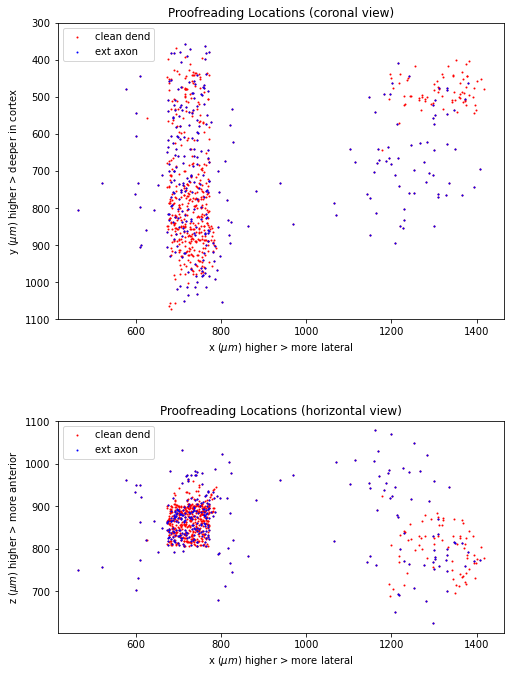

In [20]:
# Let's use this to plot the locations of the annotations

# First let's query cells for those whose axons have a status of extended.
# In the query, we will split the positions into seperate columns
# and convert the units to um, by specifying units of 1000nm for all 3 dimensions
clean_dend_df = client.materialize.query_table('proofreading_status_public_release',
                                              filter_in_dict={'status_dendrite':['clean', 'extended']},
                                              split_positions=True,
                                              desired_resolution=[1000,1000,1000])
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'},
                                             split_positions=True,
                                             desired_resolution=(1000,1000,1000))

# make a new axis with two subplots
fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# plot each dataframe in a different color
ax1.scatter(clean_dend_df.pt_position_x, clean_dend_df.pt_position_y, c='r',s=1)
ax1.scatter(ext_axon_df.pt_position_x, ext_axon_df.pt_position_y, c='b',s=1)


# label some axis, make x,y scaling same
ax1.set_xlabel('x ($\mu m$) higher > more lateral')
ax1.set_ylabel('y ($\mu m$) higher > deeper in cortex')
# to keep the pia 'up'
ax1.set_ylim(1100,300)
ax1.set_title('Proofreading Locations (coronal view)')

# plot the same thing in x,z
ax2.scatter(clean_dend_df.pt_position_x, clean_dend_df.pt_position_z, c='r', s=1)
ax2.scatter(ext_axon_df.pt_position_x, ext_axon_df.pt_position_z, c='b',s=1)

ax2.set_xlabel('x ($\mu m$) higher > more lateral')
ax2.set_ylabel('z ($\mu m$) higher > more anterior')
ax2.set_title('Proofreading Locations (horizontal view)')
ax2.set_aspect('equal')
ax1.legend(['clean dend', 'ext axon'])
ax2.legend(['clean dend', 'ext axon'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Coordinate System</h2>
Below is a diagram to help you visualize the coordinate system plotted above.  
</div>


<img src="../resources/SWDB_EM_CoordinateSystem_v0.png"> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Querying for synapses</h2>
Let's pick out a cell ID of an excitatory neuron and then find all the synapses onto that neuron</div>


In [21]:
neuron_id  = clean_dend_df.iloc[0].pt_root_id
neuron_id

864691135355207375

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we are ready to query synapses for this neuron. Because the analysis database can, in principle, handle multiple different sources of synapses, we have to specify which synapse table we want to use. The current table holding the most up to date automated synapse detection is called `synapses_pni_2`.  The "info" service has stored the default synapse table you should use for each datastack so you don't need to remember it.

Because synapses are such a common query, we have written a wrapper method `synapse_query` which uses the default synapse table and simplifies the syntax. Here is a list of it's key arguments ..

- `post_ids`: Use to specify that you want synpases onto these neurons, in other words, you want inputs to these neurons. 
- `pre_ids`: Use to specify that you want synapses from these neurons, in other words, you want outputs from these neurons. 

Setting both `pre_ids` and `post_ids` will return only synapses that are from the `pre_ids` onto the `post_ids`.

If you pass neither you are essentially asking for all the synapses, 330 million of them, several hundred gigabytes of data.
We won't do that, and in general the service will only give you the first 200K of any query.
You'll see a warning if you hit this limit.

You also have the other options available to you to split_positions and convert units with desired_resolution if you want.
</div>

In [22]:
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(post_ids = neuron_id)
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_pni_2
(2153, 10)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,183361830,t,90936347065790923,864691136577758484,90936347065797444,864691135355207375,3180,"[190268, 209432, 22392]","[190214, 209538, 22400]","[190251, 209518, 22399]"
1,148880070,t,88052259480540761,864691136850126446,88052259480523401,864691135355207375,7360,"[169368, 216848, 23121]","[169400, 216950, 23113]","[169405, 216905, 23124]"
2,183244702,t,91008983485591311,864691135209212230,91008983485587468,864691135355207375,1076,"[190802, 226240, 21899]","[190818, 226208, 21888]","[190772, 226243, 21891]"
3,169816275,t,89741178060237102,864691135599313860,89670809316055143,864691135355207375,13768,"[181342, 217436, 23070]","[181254, 217484, 23078]","[181284, 217478, 23076]"
4,177789108,t,90709297780185782,864691134892313102,90709297780172814,864691135355207375,5432,"[188806, 90392, 21174]","[188838, 90378, 21166]","[188842, 90390, 21169]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Each row in this table is a single synapse. You should see that the value in the post_pt_root_id column is the same for all, and equals the id you selected above. </br>


<h3> Synapse Table Descriptions</h3>
Here's a breakdown of what each of those columns mean.
</div>

<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>id</td>
        <td>The ID that is specific to this synapse annotation</td>
    </tr>
    <tr>
        <td>pre_pt_supervoxel_id</td>
        <td>a bookkeeping column for the presynaptic side </td>
    </tr>
    <tr>
        <td>pre_pt_root_id</td>
        <td>the ID of the cell on the presynaptic side</td>
    </tr>
    <tr>
        <td>post_pt_supervoxel_id</td>
        <td>Same bookkeeping column as pre_pt but for the post synaptic side.</td>
    </tr>
    <tr>
        <td>post_pt_root_id</td>
        <td>Same as pre_pt but for the post synaptic side</td>
    </tr>
    <tr>
        <td>size</td>
        <td>The size of the synaptic cleft in units of 4,4,40 voxels.</td>
    </tr>
    <tr>
        <td>pre_pt_position</td>
        <td>a point that is in the pre-synaptic terminal of this synapse  </td>
    </tr>
    <tr>
        <td>post_pt_position</td>
        <td>Same as pre_pt but for the post synaptic side.</td>
    </tr>
    <tr>
        <td>ctr_pt_position</td>
        <td>a point that is on the center of the synapse</td>
    </tr>
</table>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<h5>Note in this table there are 3 position columns. Like the other table, they will be given by default in the units specified in the metadata (4,4,40 nm), which matches the default Neuroglancer coordinates.</h5>
</div>

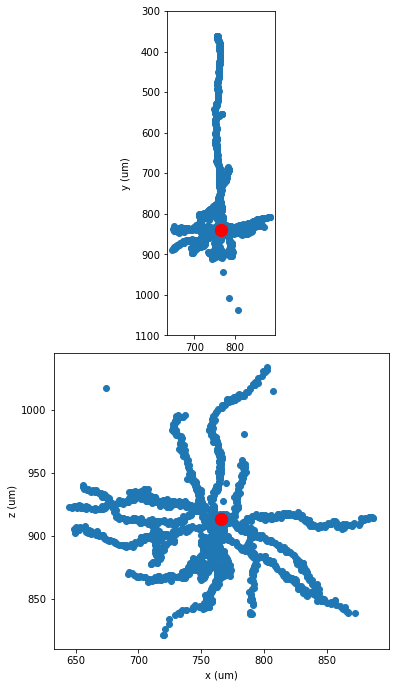

In [23]:
# Lets query this neuron again, but now splitting columns and converting to um
post_synapse_df = client.materialize.synapse_query(post_ids = neuron_id,
                                                   desired_resolution=(1000,1000,1000))

# Lets make a matrix of synapse positions for this neuron
syn_pos_nm = np.vstack(post_synapse_df['ctr_pt_position'].values)
# and plot their positions in x,y along with the soma position as a red circle
fig = plt.figure(figsize=(6,12))
ax1 = fig.add_subplot(2, 1, 1, aspect='equal')
ax2 = fig.add_subplot(2, 1, 2,  aspect='equal')
ax1.scatter(syn_pos_nm[:,0], syn_pos_nm[:,1])

# add the soma position as a red circle
soma_pos = clean_dend_df[['pt_position_x','pt_position_y','pt_position_z']].values
ax1.scatter([soma_pos[0,0]],[soma_pos[0,1]],c='r',s=150)
ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
ax1.set_ylim(1100,300)

ax2.scatter(syn_pos_nm[:,0], syn_pos_nm[:,2])

# add the soma position as a red circle
ax2.scatter([soma_pos[0,0]],[soma_pos[0,2]],c='r',s=150)
ax2.set_xlabel('x (um)')
ax2.set_ylabel('z (um)')
plt.subplots_adjust(hspace=0.01)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now lets figure out which excitatory neuron makes the most synapses onto this neuron
</div>

In [24]:
# We can use pandas groupby to count number of synapses from different neurons.
# If we use groupby followed by transform with len as the aggregation function
# We can return a series which is the same length as the dataframe (one row per synapse)
# but contains how many other synapses are in that connection.
# Since length is the same result no matter what the column contains,
# you can pick any column to aggregate on.  Here we choose the 'id' column

syn_in_conn=post_synapse_df.groupby('pre_pt_root_id')['id'].transform(len)
# save this result in a new column
post_synapse_df['syn_in_conn']=syn_in_conn
post_synapse_df[['id', 'pre_pt_root_id', 'size','syn_in_conn']].sort_values('syn_in_conn', ascending=False).head()

,id,pre_pt_root_id,size,syn_in_conn
1867,190081077,864691135303399847,5532,6
896,181730232,864691135303399847,4400,6
1520,181730731,864691135640423876,6180,6
551,183176890,864691135303399847,3156,6
526,183178227,864691135640423876,3148,6


In [25]:

# are any of these synapses from our list of extended axons?
is_from_extended = post_synapse_df.pre_pt_root_id.isin(ext_axon_df.pt_root_id.values)
extended_to_neuron_df=post_synapse_df[is_from_extended]
extended_to_neuron_df[['id',
                'post_pt_root_id',
                'pre_pt_root_id',
                'syn_in_conn',
                'size']]

,id,post_pt_root_id,pre_pt_root_id,syn_in_conn,size
188,183361942,864691135355207375,864691135538472562,5,1884
289,183204466,864691135355207375,864691136423071535,3,2208
367,195041615,864691135355207375,864691136329289962,1,2160
413,183178374,864691135355207375,864691137053995126,1,8980
453,183176375,864691135355207375,864691136099960181,2,3880
477,183178523,864691135355207375,864691135926631636,1,3252
507,169081334,864691135355207375,864691135538472562,5,856
514,169003861,864691135355207375,864691135538472562,5,3472
551,183176890,864691135355207375,864691135303399847,6,3156
635,183178487,864691135355207375,864691135303399847,6,4196


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Lets get the ID of the neuron that has the largest number of synapses onto this neuron
</div>

In [26]:
# find the neuron with the most synapses
max_input_idx = extended_to_neuron_df.syn_in_conn.idxmax()
max_input_neuron = extended_to_neuron_df.loc[max_input_idx].pre_pt_root_id
print(max_input_neuron)

# Print out the synapses from this neuron as a double check.
# You can see there are 6 of them
# which is the largest value of syn_in_conn in the above table
extended_to_neuron_df[extended_to_neuron_df.pre_pt_root_id == max_input_neuron]

864691135303399847


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,syn_in_conn
551,183176890,t,90725240900123743,864691135303399847,90725240900140264,864691135355207375,3156,"[754.456, 838.264, 907.9200000000001]","[754.8240000000001, 838.296, 908.48]","[754.6320000000001, 838.208, 908.16]",6
635,183178487,t,91147247206717083,864691135303399847,91147247206712241,864691135355207375,4196,"[766.8240000000001, 831.144, 906.44]","[766.496, 831.208, 906.2]","[766.6, 831.432, 906.5600000000001]",6
732,183204362,t,91076878462543837,864691135303399847,91147247206697278,864691135355207375,4928,"[765.936, 831.248, 906.24]","[766.112, 831.2, 905.84]","[766.016, 831.144, 906.04]",6
896,181730232,t,90866047108317519,864691135303399847,90866047108308777,864691135355207375,4400,"[759.224, 838.688, 919.4]","[759.6320000000001, 838.64, 919.16]","[759.448, 838.568, 919.4]",6
1867,190081077,t,91147109701005276,864691135303399847,91147109701010829,864691135355207375,5532,"[767.648, 826.912, 899.6]","[768.064, 826.424, 899.96]","[767.652, 826.832, 899.72]",6
1969,183362185,t,91006578371072102,864691135303399847,91006578371060828,864691135355207375,5208,"[763.768, 834.216, 898.2]","[763.344, 834.104, 898.0]","[763.576, 833.96, 898.08]",6


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Linking synapses to cell types</h2>
You might want to link synapses to the cell bodies or cell classes of the pre or post-synaptic cells.  To do this, you want to 'merge' (See <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html"> pandas merge docs </a> ) the information between a synapse table and a table of cells. </div>

We have a few different tables that have lists of cells that have different kinds of metadata and meanings. 

<table style={float:left}>
    <tr>
        <td><h4>tables of cells</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
    <td>nucleus_detection_v0</td>
    <td>a table with every nucleus detection in the dataset (includes some false positives)</td>
    </tr>
    <tr>
    <td>aibs_soma_nuc_metamodel_preds_v117</td>
    <td>A machine learning model with cell type predictions for 86916 cells based on soma and nucleus features, references nucleus_detection_v0</td>
    </tr>
    <tr>
    <td>nucleus_neuron_svm</td>
    <td>A machine learning model with predictions for 171818 nucleus detectionss, predicts neurons from non-neurons (glia+errors)</td>
    </tr>
    <tr>
    <td>allen_v1_column_types_slanted</td>
    <td>A table of human expert powered neuronal cell type calls from the "column"</td>
    </tr>
    <tr>
    <td>aibs_column_nonneuronal</td>
    <td>A table of human expert powered non-neuronal cell type calls from the "column"</td>
    </tr>
    <tr>
    <td>functional_coreg</td>
    <td>A list of 9608 cells that have functional coregistration, prioritized towards targets of excitatory neurons with extended axons </td>
    </tr>
    <tr>
    <td>func_unit_em_match_release</td>
    <td>A list of 100 cells that have functional coregistration spread evenly throughout the volume. </td>
    </tr>

</table>

In [27]:
# lets pull out the table that lists the cell type predictions in the dataset
# it will get automatically merged with the nucleus_dection_v0 table
# to give us the positions of those nuclei.
neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')
neuron_soma_df.head()


,id,valid,target_id,classification_system,cell_type,id_ref,valid__ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,553,t,498173,aibs_neuronal,6P-IT,498173,t,308.176159,103884538719281829,864691136091295156,"[284688, 211936, 15566]","[nan, nan, nan]","[nan, nan, nan]"
1,4509,t,487329,aibs_neuronal,MC,487329,t,295.937638,105279407463397326,864691135975935434,"[294544, 118624, 21745]","[nan, nan, nan]","[nan, nan, nan]"
2,4693,t,106662,aibs_neuronal,23P,106662,t,230.148178,79524515478544304,864691136084076652,"[107056, 119248, 19414]","[nan, nan, nan]","[nan, nan, nan]"
3,5061,t,271350,aibs_neuronal,6P-CT,271350,t,305.328128,87351114324194368,864691135937342005,"[163920, 235968, 20875]","[nan, nan, nan]","[nan, nan, nan]"
4,8652,t,456040,aibs_neuronal,MC,456040,t,257.463910,101129507251445952,864691136084057196,"[264544, 132528, 23988]","[nan, nan, nan]","[nan, nan, nan]"


In [28]:
# where did these predictions come from?
client.materialize.get_table_metadata('aibs_soma_nuc_metamodel_preds_v117')['description']

'This table contains cell-type predictions for cells throughout the entire dataset, based on a soma and nucleus feature trained metamodel (Elabbady 2022 https://doi.org/10.1101/2022.07.20.499976). This is a reference table where id refers to the unique nucleus id in the "nucleus_detection_v0" table. Classification_system refers to the coarse predictions and cell_type denotes noneuronal class and neuronal subclass predictions. Errors and soma-soma mergers have been filtered out. For questions please contact Leila Elabbady or Forrest Collman.[Note: This table "aibs_soma_nuc_metamodel_preds_v117" will update the "target_id" foreign_key when updates are made to the "nucleus_detection_v0" table] [Note: This table \'aibs_soma_nuc_metamodel_preds_v117\' will update the \'target_id\' foreign_key when updates are made to the \'nucleus_detection_v0\' table] '

In [29]:
# you can see how many cells based on a rough classification 
# by looking at the classification_system value_counts
neuron_soma_df.classification_system.value_counts()

aibs_neuronal       67725
aibs_nonneuronal    19191
Name: classification_system, dtype: int64

In [30]:
# you can see how many cells based on a finer classification 
# by looking at the cell_type value_counts
neuron_soma_df.cell_type.value_counts()

23P          19139
4P           13407
6P-IT        10746
5P-IT         9060
astrocyte     7724
6P-CT         5862
oligo         4998
BC            3084
microglia     3024
OPC           2483
MC            2270
5P-ET         1626
BPC           1424
pericyte       962
NGC            651
5P-NP          456
Name: cell_type, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3> Cell Type Reference Table Descriptions</h3>
Here's a breakdown of what each of those columns mean.
</div>

<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>id</td>
        <td>The ID that is specific to annotation</td>
    </tr>
        <tr>
        <td>target_id</td>
        <td>the target nucleus id that this annotation references</td>
    </tr>
    <tr>
        <td>classification_system</td>
        <td>one aibs_neuronal, or aibs_nonneuronal indicating its broad class</td>
    </tr>
    <tr>
        <td>cell_type</td>
        <td>a cell type call.. see cell type table below for legend</td> 
    </tr>
    </tr>
        <tr>
        <td>id_ref</td>
        <td>the nucleus id that this annotation references (should match target_id)</td>
    </tr>
    <tr>
        <td>valid__ref</td>
        <td>bookkeeping..can ignore</td>
    </tr>
     <tr>
        <td>volume</td>
        <td>the volume of the nucleus in um^3</td>
    </tr>
    <tr>
        <td>pt_supervoxel_id</td>
        <td>a bookkeeping column for the annotation </td>
    </tr>
    <tr>
        <td>pt_root_id</td>
        <td>the ID of the segmentation at the nucleus centroid 'pt_position'</td>
    </tr>
     <tr>
        <td>pt_position</td>
        <td>a point that is at the centroid of the nucleus segmentation (in 4,4,40 voxels by default)</td>
    </tr>
</table>
Each row in this table is a single nucleus segmentation.

<h3> Cell Type Legend</h3>
Here's a fuller text description for each cell type tag.
</div>
<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
    <tr><td>aibs_neuronal</td></tr>
    <tr><td>23P</td><td>a layer 2/3 pyramidal neuron </td></tr>
    <tr><td>4P</td><td>a layer 4 pyramidal neuron</td></tr>
    <tr><td>5P-IT</td><td>a layer 5 intertelencenphalic neuron (thin tufted)</td></tr>
    <tr><td>5P-ET</td><td>a layer 5 extra-telecenphalic neuron (thick tufted, or pyramidal tract)</td></tr>
    <tr><td>5P-NP</td><td>a layer 5 near projecting neuron</td></tr>
    <tr><td>6P-IT</td><td> a layer 6 intertelencenphalic neuron</td></tr>
    <tr><td>6P-CT</td><td>a layer 6 cortico-thalamic neuron</td></tr>
    <tr><td>BC</td><td>a basket cell</td></tr>
    <tr><td>MC</td><td>a martinotti cell</td></tr>
    <tr><td>BPC</td><td>a bipolar cell</td></tr>
    <tr><td>NGC</td><td>a neurogliaform cell</td></tr>
    <tr><td>aibs_nonneuronal</td></tr>
    <tr><td>astrocyte</td><td>an astrocyte</td></tr>
    <tr><td>oligo</td><td>an oligodendrocyte </td></tr>
    <tr><td>OPC</td><td>an oligodendrocyte precursor cell</td></tr>
    <tr><td>microglia</td><td>a microglia cell </td></tr>
    <tr><td>pericyte</td><td>a pericyte adjacent to a blood vessel</td></tr>
</table>
   
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">



In [31]:

# now that we have the cell type predictions
# lets see what we know about the cell types of the inputs
# to our neuron.

# merging in the neuron table using 'left' ensures that every row
# in the first dataframe passed (the synapse table) 
# has at least one entry in the result
# more than 1 if there is more than one on the 'right'
# (the second table passed)
ext_to_neuron_soma_df = pd.merge(extended_to_neuron_df, neuron_soma_df,
         left_on='pre_pt_root_id',
         right_on='pt_root_id',
         how='left',
         suffixes=['_syn', '_soma'])

# there are a lot of columns in the resulting merged table.
# below we will print out a subset.
# and the intepretation of the meaning of that column after the merge
#
# id_syn: the ID of the synapse
# pre_pt_root_id:  the pre_synaptic ID (don't show post_pt_root_id because its always the same)
# id_soma: the ID of the nucleus that had the matched root_id
# ctr_pt_position: position of the synapse (in microns)
# pt_position: position of the pre_synaptic nucleus (in 4,4,40 voxels... always track your units!)
# cell type: predicted cell type of pre-synaptic neuron
ext_to_neuron_soma_df[['id_syn',
                     'pre_pt_root_id',
                     'id_soma',
                     'ctr_pt_position',
                     'pt_position',
                     'cell_type']]

,id_syn,pre_pt_root_id,id_soma,ctr_pt_position,pt_position,cell_type
0,183361942,864691135538472562,6180,"[761.7, 834.9440000000001, 897.48]","[176976, 209584, 21964]",5P-IT
1,183204466,864691136423071535,1229,"[767.168, 830.32, 902.6]","[169584, 207744, 20690]",BC
2,195041615,864691136329289962,33342,"[791.032, 889.016, 886.12]","[191984, 221984, 23401]",BC
3,183178374,864691137053995126,3442,"[765.764, 833.504, 906.76]","[191712, 136928, 22487]",BC
4,183176375,864691136099960181,50752,"[751.12, 837.7760000000001, 907.08]","[172864, 229616, 21861]",BC
5,183178523,864691135926631636,40999,"[766.86, 840.064, 909.44]","[191024, 206656, 21021]",BC
6,169081334,864691135538472562,6180,"[722.664, 862.5120000000001, 928.9200000000001]","[176976, 209584, 21964]",5P-IT
7,169003861,864691135538472562,6180,"[728.784, 835.336, 908.9200000000001]","[176976, 209584, 21964]",5P-IT
8,183176890,864691135303399847,46879,"[754.6320000000001, 838.208, 908.16]","[184192, 200784, 20797]",BC
9,183178487,864691135303399847,46879,"[766.6, 831.432, 906.5600000000001]","[184192, 200784, 20797]",BC


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3>Neuron visualization</h3>
Now we could plot these synapses in 2d, but we have the detailed 3d morphology of these neurons, so why don't we look at them using neuroglancer!
 </div>

In [32]:
# this is an EM specific package for creating neuroglancer links from python
# this are functions in this helper module for making links to see individual neurons and their inputs and outputs
from nglui.statebuilder.helpers import make_neuron_neuroglancer_link

In [33]:
make_neuron_neuroglancer_link?

Signature:
make_neuron_neuroglancer_link(
    client,
    root_ids,
    return_as='html',
    shorten='always',
    show_inputs=False,
    show_outputs=False,
    sort_inputs=True,
    sort_outputs=True,
    sort_ascending=False,
    input_color=(0.25098039, 0.87843137, 0.81568627),
    output_color=(1.0, 0.38823529, 0.27843137),
    contrast=None,
    timestamp=None,
    view_kws=None,
    point_column='ctr_pt_position',
    pre_pt_root_id_col='pre_pt_root_id',
    post_pt_root_id_col='post_pt_root_id',
    input_layer_name='syns_in',
    output_layer_name='syns_out',
    ngl_url=None,
    link_text='Neuroglancer Link',
)
Docstring:
function to create a neuroglancer link view of a neuron, optionally including inputs and outputs

Args:
    client (_type_): a CAVEclient configured for datastack to visualize
    root_ids (Iterable[int]): root_ids to build around
    return_as (str, optional): one of 'html', 'json', 'url'. (default 'html')
    shorten (str, optional): if 'always' make a s

In [34]:
# you can use it to just visualize a single neuron
url=make_neuron_neuroglancer_link(client, max_input_neuron, return_as='html')
url


In [35]:
# and you can add inputs and output synapses to that neuron if you want with
# show_inputs=True and/or show_outputs=True
url=make_neuron_neuroglancer_link(client, max_input_neuron, show_inputs=True, return_as='html')
url

In [36]:
# here with both
url=make_neuron_neuroglancer_link(client, max_input_neuron, show_inputs=True, show_outputs=True, return_as='html')
url

In [37]:
# maybe you already have some curated set of synapses you want to visualize
# there's a helper function for that too
from nglui.statebuilder.helpers import make_synapse_neuroglancer_link
# how about those 6 synapses we found earlier
synapse_df = extended_to_neuron_df[extended_to_neuron_df.pre_pt_root_id == max_input_neuron]
url = make_synapse_neuroglancer_link(synapse_df, client, return_as='html')
url

In [38]:
make_synapse_neuroglancer_link(extended_to_neuron_df, client)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; padding-right:200px ; background: #F0FAFF; ">

### Setting the View

nglui offers some control over the initial position of the view and how data is visualized, while offering some fairly sensible defaults that look okay in most situations.

### Position, layout, and zoom options

View options that do not affect individual layers can be set with a dict passed to the `view_kws` argument in these helper functions, or any StateBuilder object.  These are the keys you can include:
* *show_slices* : Boolean, sets if slices are shown in the 3d view. Defaults to False.
* *layout* : `xy-3d`/`xz-3d`/`yz-3d` (sections plus 3d pane), `xy`/`yz`/`xz`/`3d` (only one pane), or `4panel` (all panes). Default is `xy-3d`.
* *show_axis_lines* : Boolean, determines if the axis lines are shown in the middle of each view.
* *show_scale_bar* : Boolean, toggles showing the scale bar.
* *orthographic* : Boolean, toggles orthographic view (objects are the same size no matter distance from camera) in the 3d pane.
* *position* : 3-element vector, determines the centered location.
* *zoom_image* : Zoom level for the imagery in units of nm per voxel. Defaults to 8.
* *zoom_3d* : Zoom level for the 3d pane. Defaults to 2000. Smaller numbers are more zoomed in.

Here's an example of setting some of these rules. Note that only providing default values for some parameters does not override the default values of others.

In [39]:
# lets say we want to aim the 3d view at the soma of the cell
# first find it's position
soma_loc=neuron_soma_df.query(f'pt_root_id=={max_input_neuron}').pt_position.values[0]

# let only show the 3d view, zoom out some, and aim the camera at the soma
# note you need to provide the position in the units of the "viewer_resolution"
# which will be set to be client.info.viewer_resolution() (4,4,40)
view_options = {'layout': '3d',
                'zoom_3d': 5000,
                'position': soma_loc}
url=make_neuron_neuroglancer_link(client, max_input_neuron, view_kws=view_options)
url


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
This package is very powerful and has general facilities for making neuroglancer links from pandas dataframes, but gets more complex to use as you do custom things.</br>

You can see examples here 
https://github.com/seung-lab/NeuroglancerAnnotationUI/tree/master/examples
</br>

If you want to build a different visualization pipeline for some dataframe you have
studying the helper functions we introduced you to here is another way to learn
https://github.com/seung-lab/NeuroglancerAnnotationUI/blob/master/src/nglui/statebuilder/helpers.py

</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Meshes

If you are interested in the detailed 3d morphology of neurons as meshes, you should use meshparty to download them, using the MeshMeta object to cache them as you will likely read the same meshes many times.
</div>

In [40]:
from meshparty import trimesh_io
mm = trimesh_io.MeshMeta(cv_path ="precomputed://gs://iarpa_microns/minnie/minnie65/seg_m343",
                         disk_cache_path='meshes',
                         cache_size=0)
# load the meshes
# meshes are available at different resolutions (called level_of_detail from 0-3)
# 0 being most details, 3 being least detailed (i know it's backwards linguistically)
level_of_detail = 2
post_mesh = mm.mesh(seg_id = neuron_id, lod=2)
pre_mesh = mm.mesh(seg_id= max_input_neuron, lod=2)
post_mesh.vertices.shape, post_mesh.faces.shape

((79663, 3), (159902, 3))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Meshes are triangular meshes, that are composed of vertices (N,3) and faces (N,3) which are indices into the vertex list
    

The Mesh class is based upon trimesh (<a href="https://github.com/mikedh/trimesh"> https://github.com/mikedh/trimesh</a>), with some added features for doing graphs

You can find the source code and documentation for mesh party here .. <a href="https://github.com/sdorkenw/MeshParty">https://github.com/sdorkenw/MeshParty </a>

We are not going to spend a lot of time today working on mesh analysis, but the data is available if you want to work on a project that uses them. 
    </div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Working with Skeletons </h3>
    
Just as the 3D mesh of the neuron is a reduced data representation of the segmentation, one can further reduce a 3D mesh into a skeleton format which can benefit certain types of analyses by making it faster/ more optimal. We have precalculated skeletons for a large number of cells in the dataset, including all the proofread cells, and many of the excitatory cells with a single soma in the dataset, and these are available on the harddrives and in the aws directory.  These skeletons are stored in an h5 file format, and also contain annotations on the skeletons that have the synapses, which skeleton nodes are axon and which are dendrite, and which are likely the apical dendrite of excitatory neurons. 
    
The Meshwork library allows us to easily store these representations and helps us relate them to each other. A Meshwork object is a data structure that is designed to have three main components that are kept in sync with mesh and skeleton indices: 
    
* mesh: the graph of PCG level2 ID nodes that are skeletonized, stored as a standard meshparty mesh. Note that this is not the high resolution mesh described above.
* skeleton: a meshparty skeleton,
* anno : is a class that holds dataframes and adds some extra info to keep track of indexing. 
    
In addition, the meshwork object itself has a number of skeleton-like functions. For the most part of this tutorial, we will focus on using the skeleton object.

</div>

In [42]:
from meshparty import meshwork

# the files are named according to the segid and the nucleus_id of each cell
# this is to keep things straight for us as there are often many versions of 
# the same nucleus during proofreading. 
# so lets look up the nuc_id of our neuron
nuc_id=neuron_soma_df.query(f'pt_root_id=={max_input_neuron}').target_id.values[0]
mesh_filename = f"{max_input_neuron}_{nuc_id}.h5"
nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Attributes of meshworks objects:
    
    nrn.mesh, nrn.skeleton, nrn.anno

    
Let us now try to visualize the skeleton: nrn.skeleton:
</div>

In [43]:
# a skeleton is composed of vertices [x,y,z] locations in nanometers

# and edges, [i,j] indices into vertices, which indicate
# a connection between those vertices from i>j
# this forms a graph, where all edges eventually lead back
# to the 'root' at the soma of the neuron

nrn.skeleton.vertices

array([[ 458232.,  844056.,  929160.],
       [ 457792.,  845144.,  929240.],
       [ 459040.,  843752.,  928640.],
       ...,
       [1108952.,  753880.,  826280.],
       [1110712.,  754144.,  825880.],
       [ 736768.,  803136.,  831880.]])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Meshwork nrn.mesh vs nrn.skeleton </h3>
    
Skeletons are "tree-like", where every vertex (except the root vertex) has a single parent that is closer to the root than it, and any number of child vertices.
Because of this, for a skeleton there are well-defined directions "away from root" and "towards root".
A few types of vertices have special names:
* Branch point: vertices with two or more children, where a neuronal process splits.
* End point: vertices with no childen, where a neuronal process ends.
* Root point: The one vertex with no parent node. By convention, we typically set the root vertex at the cell body, so these are equivalent to "away from soma" and "towards soma".
* Segment: A collection of vertices along an unbranched region, between one branch point and the next end point or branch point downstream.
    
Meshes are arbitrary collections of vertices and edges, but do not have a notion of "parent" or "child" "branch point" or "end point".
Here, this means the "mesh" used here includes a vertex for every level 2 chunk, even where it is thick like at a cell body or very thick dendrite.
However, by default this means that there is not always a well-defined notion of parent or child nodes, or towards or away from root.
    
To handle this, the meshwork object associates each mesh vertices with a single nearby skeleton vertex, and each skeleton vertex is associated with one or more mesh vertices.
By representing data this way, annotations like synapses can be directly associated with a mesh vertex (because synapses can be anywhere on the object) and then mapped to the skeleton in order to enjoy the topological benefits of the skeleton representation.
</div>



In [44]:
# By the definition of skeleton vs mesh, we would expect that mesh contains more vertices than the skeleton. 
# We can see this by looking at the size of the skeleton vertex location array vs the size of the mesh vertex location array.

print('Skeleton vertices array length:', len(nrn.skeleton.vertices))
print('Mesh vertices array length:', len(nrn.mesh.vertices))

Skeleton vertices array length: 10225
Mesh vertices array length: 16262


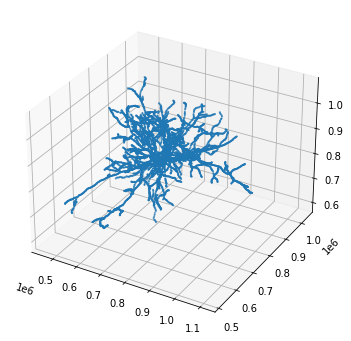

In [143]:
#Let us try to visualize the skeleton:
# Visualize the whole skeleton 

# here's a simple way to plot vertices of the skeleton
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook 

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(nrn.skeleton.vertices[:,0], nrn.skeleton.vertices[:,1], nrn.skeleton.vertices[:,2], s=1)

# you can spin this graph with left click
# or select the box tool and then zoom with right click and drag
# (two finger drag if on touchpad)
# if you zoom in you can see that this is just points in space
# no edges!

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Skeleton Properties

To plot this skeleton in a more sophisticated way, you have to start thinking
of it as a graph, and the meshwork object has a bunch of tools and properties to help you
utilize the skeleton graph.

Let's list some of the most useful ones below </br>
You access each of these with nrn.skeleton.*</br>
Use the ? to read more details about each one

## properties
* **branch_points**: a list of skeleton vertices which are branches
* **root**: the skeleton vertice which is the soma
* **distance_to_root**: an array the length of vertices which tells you how far away from the root each vertex is
* **root_position**: the position of the root node in nanometers
* **end_points**: the tips of the neuron
* **cover_paths**: a list of arrays containing vertex indices that describe individual paths that in total cover the neuron without repeating a vertex. Each path starts at an end point and continues toward root, stopping once it gets to a vertex already listed in a previously defined path. Paths are ordered to start with the end points farthest from root first. Each skeleton vertex appears in exactly one cover path. 
* **csgraph**: a scipy.sparse.csr.csr_matrix containing a graph representation of the skeleton. Useful to do more advanced graph operations and algorithms. https://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html
* **kdtree**: a scipy.spatial.ckdtree.cKDTree containing the vertices of skeleton as a kdtree. Useful for quickly finding points that are nearby. https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html

## methods
* **path_length(paths=None)**: the path length of the whole neuron if no arguments, or pass a list of paths to get the path length of that. A path is just a list of vertices which are connected by edges.
* **path_to_root(vertex_index)**: returns the path to the root from the passed vertex
* **path_between(source_index, target_index)**: the shortest path between the source vertex index and the target vertex index
* **child_nodes(vinds)**: a list of arrays listing the children of the vertex indices passed in
* **parent_nodes(vinds)**: an array listing the parent of the vertex indices passed in
* **

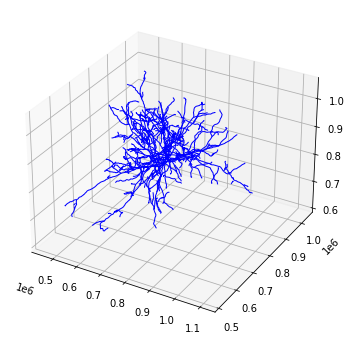

In [46]:
# So a better way to plot a neuron is to use cover_paths
# and plot those as 3d lines
def plot_neuron_skeleton(neuron, ax, c='b', linewidth=1):

    for cover_path in neuron.skeleton.cover_paths:
        path_verts = neuron.skeleton.vertices[cover_path,:]
        ax.plot(path_verts[:,0], path_verts[:,1], path_verts[:,2], c=c, linewidth=linewidth)

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')   
plot_neuron_skeleton(nrn, ax)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3>Indexing And Selecting Sets of Interesting Points</h3>

Ok, you are probably really fried by now, but here is one important thing to remember about this meshworks object. The meshworks object contains a mesh with lots of vertices and a skeleton which holds a subset of these vertices. Therefore, in python these points have different "indices" in the mesh and skeleton. For example, if the mesh contains 10000 vertices, the indexing of those would run from 0 - 9999. The skeleton, which contains a subset of 100 of these would have indexing from 0-99. How would you figure out which of the mesh vertices these correspond to?
    
Luckily, we have some really nifty functions that help us distinguish those:
    
Let us first look at some attributes in the meshworks objects:
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    A few nifty function for subselecting points: "downstream points" and "path_between".
    
For a given point, downstream points are defined as points on paths from endpoints to the root which are further than the given point. For example, if the skeleton path is : A-B-C-D-E where A is the root, D and E are downstream points of C. With branching, this can be more complex. To find the downstream points from say the 9th branch point, we can do:
</div>

In [47]:
#Downstream points

nrn.downstream_of(nrn.branch_points[9])

JointMeshIndex([ 131,  141,  142,  143,  157,  158,  159,  160,  161,
                 162,  163,  164,  165,  166,  167,  168,  169,  170,
                 171,  172,  173,  174,  175,  176,  194,  195,  196,
                 197,  198,  199,  200,  201,  202,  203,  204,  205,
                 206,  207,  208,  209,  210,  211,  212,  213,  228,
                 229,  230,  231,  232,  233,  234,  235,  236,  237,
                 238,  239,  249,  250,  251,  252,  253,  254,  255,
                 271,  272,  273,  274,  275,  276,  277,  278,  279,
                 280,  281,  282,  283,  297,  298,  299,  300,  301,
                 302,  303,  304,  305,  306,  307,  308,  309,  310,
                 311,  312,  313,  314,  332,  333,  334,  335,  336,
                 337,  338,  339,  340,  341,  342,  343,  344,  345,
                 346,  347,  348,  349,  364,  365,  366,  387,  388,
                 389,  390,  391,  408,  409,  410,  411,  412,  413,
                 414

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Path between returns the vertices from one point to another. For example, we can get the every mesh vertex from the end point 5 to the root point.
As a quick visualization, we can look at the distance to root along the, showing that it is descreasing.
</div>

Text(0, 0.5, 'Vertex along path')

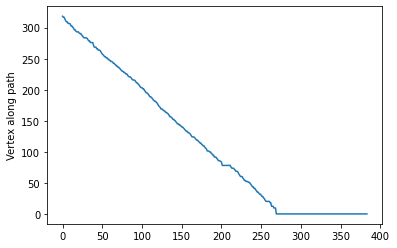

In [74]:
fig, ax = plt.subplots()
ax.plot(
    nrn.distance_to_root(
        nrn.path_between(
            nrn.end_points[5],
            nrn.root,
        )
    ) / 1_000,
)

ax.set_ylabel('Distance from root ($\mu m$)')
ax.set_ylabel('Vertex along path')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Masking</h3>
Just like meshparty meshes, we can mask the meshwork object. Like all basic meshwork functions, the expected input is in mesh vertices. Importantly, doing so will be synchronized across the mesh, the skeleton, and annotations. Do not use the nrn.mesh.apply_mask or nrn.skeleton.apply_mask functions
    
</div>

In [54]:
# If you have a collection of vertices, you can turn it into a mesh mask with `.to_mesh_mask`.
# The resulting array has a True everywhere with a vertex and a false everywhere else, and thus are useful for masking.
nrn.skeleton.cover_paths[0].to_mesh_mask

array([False, False, False, ...,  True,  True,  True])

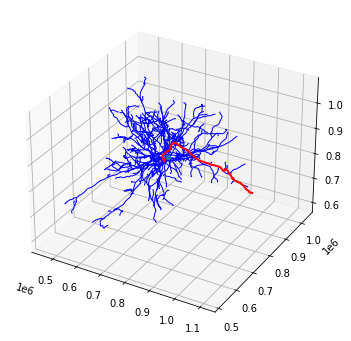

In [58]:
# Let's now use masking to highlight one particular cover path.

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection="3d")

plot_neuron_skeleton(nrn, ax, "b")

nrn.reset_mask()  # VERY IMPORTANT - needed to ensure the mask query is run on the whole object

nrn.apply_mask(nrn.skeleton.cover_paths[0].to_mesh_mask)

plot_neuron_skeleton(nrn, ax, "r", linewidth=2)
ax.scatter(
    nrn.skeleton.root_position[0],
    nrn.skeleton.root_position[1],
    nrn.skeleton.root_position[2],
)
nrn.reset_mask()  # if you are going to do any more operations after this, make sure this is reset

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3>Note: Temporary masking with mask_context</h3>
If you are doing a pattern like above where you mask, do an operation, and then reset the mask there is a convenient alternative method called "mask context" that will automatically handle the reseting for you, leaving the nrn back in the same state it was in when you started.
</div>

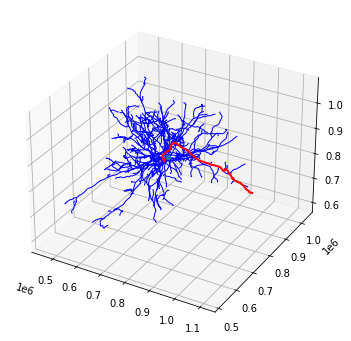

In [66]:
# Same as above with mask_context.

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection="3d")

plot_neuron_skeleton(nrn, ax, "b")
ax.scatter(
    nrn.skeleton.root_position[0],
    nrn.skeleton.root_position[1],
    nrn.skeleton.root_position[2],
)

# This part is equivalent to:
# nrn.apply_mask( nrn.skeleton.cover_paths[0].to_mesh_mask )
# plot_neuron_skeleton(nrn, ax, "r", linewidth=2)
# nrn.reset_mask()

with nrn.mask_context( nrn.skeleton.cover_paths[0].to_mesh_mask ):
    plot_neuron_skeleton(nrn, ax, "r", linewidth=2)

In [67]:
nrn.anno

Data tables: ['apical_mesh_labels', 'basal_mesh_labels', 'is_axon', 'lvl2_ids', 'post_syn', 'pre_syn', 'remaining_axon', 'segment_properties', 'soma_row', 'vol_prop']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Annotations</h3>
`nrn.anno` has set of dataframes containing some additional information for analysis. To find out what information it contains, look at the table_names attribute: 
</div>

In [70]:
print(nrn.anno.table_names)

['apical_mesh_labels', 'basal_mesh_labels', 'is_axon', 'lvl2_ids', 'post_syn', 'pre_syn', 'remaining_axon', 'segment_properties', 'soma_row', 'vol_prop']


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

For the neurons that have been computed, there is a consisent set of annotation tables:
* **apical_mesh_labels**: List of vertices that have been labeled as part of the apical dendrite
* **basal_mesh_labels**: List of vertices that have been labeled as part of the basal dendrite
* **is_axon**: List of vertices that have been labeled as part of the true axon
* **lvl2_ids**: Gives the PCG level 2 id for each mesh vertex
* **post_syn**: Gives the postsynaptic sites (inputs) for the cell, including the full dataframe as well as which mesh vertex each synapse is associated with
* **pre_syn**: Gives the presynaptic sites (outputs) for the cell, including the full dataframe as well as which mesh vertex each synapse is associated with
* **remaining_axon**: For neurons with automated proofreading to remove axons, this contains vertices that were not removed but still labeled as axon
* **segment_properties**: For each vertex, information about the approximate radius, surface area, volume, and length of the segment it is on.
* **soma_row**: Information about the soma location and nucleus id of the neuron.
* **vol_prop**: For every vertex, the information about the volume and surface area of the level 2 id it is associated with.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## How do annotations work?

Let's look at the pre_syn annotation. You can access the data as a dataframe with `.df`
    
</div>

In [89]:
nrn.anno.pre_syn.df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,pre_pt_mesh_ind_filt
0,"[178272, 196214, 19798]",162714527,"[178316, 196238, 19795]",864691135214030313,89316078907705509,161373672945222007,9138,"[178240, 196190, 19797]",864691135303399847,89316078907709246,1228,t,9138
1,"[144427, 191468, 22241]",103873967,"[144428, 191334, 22235]",864691135577673156,84671123652091221,156658348945572342,1312,"[144326, 191374, 22244]",864691135303399847,84600754907928939,16428,t,1312
2,"[169273, 170350, 18638]",147995867,"[169424, 170394, 18646]",864691135449114610,88046005404306829,160103599441969682,6717,"[169316, 170364, 18642]",864691135303399847,88046005404305472,13724,t,6717
3,"[215043, 203642, 20684]",221201970,"[215082, 203640, 20681]",864691135462795070,94383659414721906,166370884708204943,15317,"[215052, 203654, 20688]",864691135303399847,94313290670552806,644,t,15317
4,"[160444, 200030, 21601]",129506098,"[160364, 200070, 21605]",864691135571557925,86853722885485348,158911316923252947,4340,"[160428, 199954, 21606]",864691135303399847,86853722885482573,13468,t,4340
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2340,"[184105, 204056, 21753]",175378767,"[184016, 204068, 21755]",864691136534887842,90091234873624362,162148828911239680,11008,"[184138, 204098, 21755]",864691135303399847,90091234873624327,7540,t,11008
2341,"[143710, 188572, 19367]",101222987,"[143812, 188652, 19373]",864691135269684133,84530042163895632,156587636201358073,1251,"[143714, 188642, 19369]",864691135303399847,84530042163897907,5088,t,1251
2342,"[183990, 199348, 24507]",174444399,"[183940, 199390, 24518]",864691135269672357,90090616734138937,162148142052016924,10947,"[183904, 199282, 24509]",864691135303399847,90090548014600160,3808,t,10947
2343,"[143690, 191343, 19432]",101222920,"[143648, 191280, 19432]",864691135575217438,84530385761387875,156587979798742008,1261,"[143650, 191322, 19419]",864691135303399847,84530385761376136,6164,t,1261


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
The in-built properties and functions of a meshworks object allow you to connect the dataframe with mesh/skeleton information and operations. 
    
For example, you can get the mesh index for each row with `.mesh_index`. 
</div>

In [91]:
nrn.anno.pre_syn.mesh_index

JointMeshIndex([ 9138,  1312,  6717, ..., 10947,  1261,  2656])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
 
And the skeleton index for each row with `.skel_index`. 
</div>

In [92]:
nrn.anno.pre_syn.skel_index

JointSkeletonIndex([    0,     1,     5, ..., 10215, 10220, 10221])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
These mesh indices can be linked up to the meshwork class functions trivially using this information:
    </div>

In [93]:
# We can combine this with the distance to root function to get the distance from each point to the root in microns.

nrn.distance_to_root(nrn.anno.pre_syn.mesh_index)/1000 # in microns

array([205.72368717, 288.09277779, 318.63682938, ..., 373.27768368,
       237.53418513, 216.06620055])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>Filtering annotations by mesh vertices</h3>
   
Each annotation table has a "filter_query" method that takes a boolean mesh mask and returns only those rows of the dataframe associated with those particular locations on the mesh.
Let's use what we learned above in two examples: first, getting all input synapses within 50 microns of the root and second, getting all input synapses on one particular branch off of the soma.
</div>

In [123]:
# Get distance to root for all vertices
dtr = nrn.distance_to_root() / 1_000

nrn.anno.post_syn.filter_query( dtr < 50).df

,ctr_pt_position,id,post_pt_level2_id,post_pt_mesh_ind,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,post_pt_mesh_ind_filt
1,"[184464, 199246, 20812]",174045212,162218510326432358,11100,"[184486, 199322, 20809]",864691135303399847,90160916288906297,"[184412, 199212, 20815]",864691135493407428,90160916288909777,1272,t,11100
3,"[186792, 199676, 20341]",175264044,162500053955510645,11678,"[186866, 199646, 20339]",864691135303399847,90442459918038472,"[186728, 199586, 20339]",864691135394307317,90442459918040746,4676,t,11678
7,"[186997, 195779, 19941]",172470904,162569941596242911,11791,"[187050, 195814, 19942]",864691135303399847,90512347558864651,"[186986, 195788, 19943]",864691135541403076,90512347558865592,6804,t,11791
8,"[187582, 201054, 20479]",175838387,162640997602296368,11973,"[187630, 201000, 20472]",864691135303399847,90583403565041527,"[187540, 201084, 20470]",864691135660762352,90583403565040655,1056,t,11973
15,"[184005, 206498, 20808]",176439996,162149103654928963,11014,"[183980, 206512, 20806]",864691135303399847,90091509617384794,"[183942, 206432, 20809]",864691136830074734,90091509617386964,6000,t,11014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6775,"[186983, 195471, 19915]",176363047,162569872876766209,11787,"[187000, 195506, 19913]",864691135303399847,90512278839371631,"[186944, 195428, 19918]",864691135635813828,90512278839378650,12344,t,11787
6782,"[181627, 196403, 20594]",168697797,161795954263982414,10197,"[181596, 196310, 20599]",864691135303399847,89738360226231499,"[181654, 196352, 20595]",864691135605852356,89738360226222227,1688,t,10197
6783,"[186970, 196308, 19966]",172508385,162499572919173161,11659,"[186896, 196240, 19974]",864691135303399847,90441978881271739,"[187046, 196382, 19962]",864691135374059081,90512416278387184,5548,t,11659
6787,"[183781, 199896, 20639]",175836642,162077910277030237,10803,"[183680, 199916, 20649]",864691135303399847,90020316239324071,"[183726, 199804, 20644]",864691136601809105,90020247519864868,8948,t,10803


In [131]:
root_children = nrn.child_index(nrn.root) # Gets all child vertices of the root, which amounts to the start of branch that comes off the soma.

# Pick one of the children
branch_mask = nrn.downstream_of( root_children[3] ).to_mesh_mask

nrn.anno.post_syn.filter_query( branch_mask ).df

,ctr_pt_position,id,post_pt_level2_id,post_pt_mesh_ind,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,post_pt_mesh_ind_filt
3,"[186792, 199676, 20341]",175264044,162500053955510645,11678,"[186866, 199646, 20339]",864691135303399847,90442459918038472,"[186728, 199586, 20339]",864691135394307317,90442459918040746,4676,t,11678
7,"[186997, 195779, 19941]",172470904,162569941596242911,11791,"[187050, 195814, 19942]",864691135303399847,90512347558864651,"[186986, 195788, 19943]",864691135541403076,90512347558865592,6804,t,11791
8,"[187582, 201054, 20479]",175838387,162640997602296368,11973,"[187630, 201000, 20472]",864691135303399847,90583403565041527,"[187540, 201084, 20470]",864691135660762352,90583403565040655,1056,t,11973
16,"[180456, 183005, 18934]",168979383,161653429800796872,9767,"[180496, 183026, 18929]",864691135303399847,89595835763516509,"[180484, 182942, 18940]",864691135389882098,89595767044010286,4344,t,9767
27,"[194651, 211062, 20683]",187861283,163627465757950213,13452,"[194678, 211108, 20676]",864691135303399847,91569871720290257,"[194586, 210996, 20689]",864691135527205003,91499502976089758,3408,t,13452
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6775,"[186983, 195471, 19915]",176363047,162569872876766209,11787,"[187000, 195506, 19913]",864691135303399847,90512278839371631,"[186944, 195428, 19918]",864691135635813828,90512278839378650,12344,t,11787
6777,"[185124, 189952, 19781]",174799836,162287641985810677,11259,"[185108, 189900, 19777]",864691135303399847,90230047948309075,"[185100, 189988, 19780]",864691135372567538,90230047948312009,3472,t,11259
6781,"[186540, 194180, 19894]",176362687,162499297974158417,11649,"[186540, 194236, 19901]",864691135303399847,90441703936760033,"[186616, 194156, 19887]",864691136836008814,90441703936742114,13200,t,11649
6783,"[186970, 196308, 19966]",172508385,162499572919173161,11659,"[186896, 196240, 19974]",864691135303399847,90441978881271739,"[187046, 196382, 19962]",864691135374059081,90512416278387184,5548,t,11659


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can also use one set of annotations as an input to filter query from another set of annotations.
For example, due to proofreading or mistakes in machine learning, there are some synaptic outputs on the dendrite.
Let's use the 
</div>

In [140]:
# Here, we use the `is_axon` annotation, where the mesh_mask is True for every axonal vertex, and then invert it to get a mask that is True for every non-axonal vertex.

non_axon_mask = ~nrn.anno.is_axon.mesh_mask
nrn.anno.pre_syn.filter_query(non_axon_mask).df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,pre_pt_mesh_ind_filt
45,"[218250, 236214, 22357]",231641773,"[218248, 236180, 22360]",864691135785234116,94810201408261106,166867864165286564,15514,"[218188, 236292, 22354]",864691135303399847,94810270127751661,6176,t,15514
231,"[133568, 198802, 18681]",82678470,"[133508, 198754, 18672]",864691135953738504,83123972883131248,155181566920753660,500,"[133578, 198852, 18675]",864691135303399847,83123972883131409,4812,t,500
301,"[169490, 190376, 24593]",146467154,"[169446, 190336, 24600]",864691135589888011,88048686269000040,160106280306868278,6755,"[169502, 190384, 24597]",864691135303399847,88048686268995439,1996,t,6755
392,"[183310, 185506, 19205]",168933930,"[183236, 185434, 19200]",864691135383129323,89947954429087056,162005617186177680,10625,"[183286, 185552, 19203]",864691135303399847,89948023148556941,564,t,10625
755,"[186872, 208926, 20283]",176501492,"[186832, 208948, 20278]",864691133768183681,90443696868528396,162501290906092105,11731,"[186870, 208924, 20284]",864691135303399847,90443696868536657,444,t,11731
796,"[198064, 221272, 21612]",197458775,"[198008, 221190, 21611]",864691135468407122,91993458709009578,164051052746768548,13836,"[198064, 221276, 21606]",864691135303399847,91993458709005551,772,t,13836
889,"[202088, 242450, 19249]",204555855,"[202034, 242422, 19245]",864691136390732671,92559294545060763,164616888582668990,14261,"[202100, 242524, 19251]",864691135303399847,92559294545070129,168,t,14261
1172,"[190398, 220812, 20355]",182408939,"[190440, 220760, 20355]",864691135341343173,90937858625813644,162995452663300754,12553,"[190376, 220834, 20354]",864691135303399847,90937858625804121,2368,t,12553
1197,"[222358, 215512, 18844]",238528530,"[222390, 215492, 18836]",864691135668360132,95370402112988174,167427996150399498,15679,"[222312, 215482, 18851]",864691135303399847,95370402113004492,448,t,15679
1230,"[185254, 188574, 19740]",174799965,"[185252, 188578, 19741]",864691135452216051,90229841789820512,162287435827380640,11255,"[185214, 188514, 19737]",864691135303399847,90229841789820477,4192,t,11255


In [141]:
# We can even pass this synapse dataframe to neuroglancer to see if these are truly incorrect synapses, as expected:

url = make_synapse_neuroglancer_link(
    nrn.anno.pre_syn.filter_query(non_axon_mask).df,
    client,
    return_as="html"
)
url